# imports

In [208]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Tuple, Dict

import sys

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline import shared

from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
import shared


sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *


from typing import Dict
import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm.notebook import tqdm
import matplotlib.image as mpimg
import shutil
from PIL import Image
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm as tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/')

WSIS_CORTICOTROP = PATH/'corticotrop'
WSIS_GONADOTROP = PATH/'gonadotrop'

ROIS_CORTICOTROP = PATH/'corticotrop_ROIs'
ROIS_GONADOTROP = PATH/'gonadotrop_ROIs'

TILES_CORTICOTROP_1 = PATH/'tiles_corticotrop_1_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_2 = PATH/'tiles_corticotrop_2_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_3 = PATH/'tiles_corticotrop_3_scoring_function_1_thresh_0.4'

TILES_GONADOTROP_1 = PATH/'tiles_gonadotrop_1_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_2 = PATH/'tiles_gonadotrop_2_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_3 = PATH/'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'

#TEST = PATH/TEST_NAME
#TEST = PATH_LOCAL/TEST_NAME
TEST_EXPERIMENTING = PATH/'tiles_test_100_for_testing'
LABELS_CORTICOTROP_NAME = 'KortikotropHA_gelabled.xlsx'
LABELS_CORTICOTROP = PATH/LABELS_CORTICOTROP_NAME
LABELS_GONADOTROP_NAME = 'GonadotropeHA_gelabled.xlsx'
LABELS_GONADOTROP = PATH/LABELS_GONADOTROP_NAME
MODEL_PATH_NAME = 'models'
MODEL_PATH = PATH/MODEL_PATH_NAME

ROIS_EXPERIMENTING = PATH/'rois_experimenting'
TILES_EXPERIMENTING = PATH/'tiles_experimenting'

torch.backends.cudnn.benchmark=True


seed = 19
np.random.seed(seed)

num2lbs = {
    0:"acth", 
    1:"silent",  
    2:"lh", 
    3:"fsh"
}

lbs2num = {l:n for n,l in num2lbs.items()}

# data preprocessing 

## id and label funcs

In [3]:
def get_case_id_from_path(path):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

def get_slide_name_from_path(path):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    split = path.stem.split('-')
    try:
        return f'{split[0]}-{split[1]}-{split[2]}-{split[3]}'
    except IndexError:
        return f'{split[0]}-{split[1]}-{split[2]}'
    
df_c = pd.read_excel(LABELS_CORTICOTROP)

##
# since fastai orders classes in the dataloaders vocab in alphabetical order, I put numbers in front of the class names
# to get my desired order (same as the previously trained model expects)
##
def label_func(path, roi = None):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    s = path.stem  
    if('LH+FSH' in s):
        return ['2_lh','3_fsh']
    elif 'LH' in s:       
        return ['2_lh']
    elif 'FSH' in s:        
        return ['3_fsh']
    elif 'ACTH' in s:
        result = ['0_acth']
        id = get_case_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(3) in str(l.values[0]):
                result.append('1_silent')
        except:
            print(l.values)
            print(s)
            print(get_slide_name_from_path(path))
            raise
        return result

## Extract tiles from rois on the fly 

### roi paths

In [209]:
roi_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                                                        get_files=True, 
                                                                        suffix='.png', 
                                                                        recursive=True, 
                                                                        folder_name=['gonadotrop_ROIs', 'corticotrop_ROIs'])

49it [00:15,  3.14it/s]


In [210]:
roi_paths = roi_paths[:5]

In [211]:
roi_paths.items[:5]

[Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_18-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_32-LH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png')]

In [212]:
len(roi_paths.items)

5

In [213]:
len(ROIS_CORTICOTROP.ls() + ROIS_GONADOTROP.ls())

13169

### tile extraction

In [9]:
tile_size = 1024

In [10]:
tilesummaries = tiles.WsiOrROIToTilesMultithreaded(wsi_paths=roi_paths.items, 
                                                   tiles_folder_path=None, 
                                                   tile_height=tile_size, 
                                                   tile_width=tile_size, 
                                                   minimal_acceptable_tile_height=0.7, 
                                                   minimal_acceptable_tile_width=0.7, 
                                                   tile_score_thresh=0.3,
                                                   tile_scoring_function=tiles.scoring_function_1, 
                                                   level=0,
                                                   save_tiles=False, 
                                                   return_as_tilesummary_object=True, 
                                                   wsi_path_to_rois=None, 
                                                   verbose=False)

100%|██████████| 5/5 [00:44<00:00, 12.33s/it]

In [ ]:
for ts in tilesummaries:
    ts.show_wsi_with_marked_tiles()

### PatientManager

In [11]:
patient_manager = PatientManager()

In [12]:
patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_case_id_from_path, #one case per patient
                                         case_id_getter= get_case_id_from_path, 
                                         slide_id_getter= get_slide_name_from_path, 
                                         labels_getter=label_func)

In [13]:
len(patient_manager.get_all_tiles())

81

In [14]:
n_splits=5
current_iteration=0
patient_manager.split_KFold_cross_validation(n_splits=n_splits, 
                                             current_iteration=current_iteration, 
                                             random_state = seed, 
                                             shuffle = True)

### data block api

In [15]:
final_size = 512
bs = 2

In [16]:
batch_tfms=[fastai2.data.transforms.Normalize.from_stats(*fastai2.vision.all.imagenet_stats)] \
.append(fastai2.vision.augment.aug_transforms(size=final_size,flip_vert=True))

In [17]:
data = fastai2.data.block.DataBlock(
        blocks=(TileImageBlock, fastai2.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.labels,
        splitter=fastai2.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms = fastai2.vision.augment.Resize(tile_size),
        batch_tfms=[])

dls = data.dataloaders(patient_manager.get_all_tiles(), bs=bs)

## Preextracted tiles

### tile paths

In [4]:
tile_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                            get_files=True, 
                                            suffix='.png', 
                                            recursive=True, 
                                            folder_name=['tiles_corticotrop_1_scoring_function_1_thresh_0.55', 
                                                         'tiles_corticotrop_2_scoring_function_1_thresh_0.55', 
                                                         'tiles_corticotrop_3_scoring_function_1_thresh_0.4', 
                                                         'tiles_gonadotrop_1_scoring_function_1_thresh_0.55', 
                                                         'tiles_gonadotrop_2_scoring_function_1_thresh_0.55', 
                                                         'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'])

49it [00:18,  2.67it/s]


In [5]:
len(tile_paths)

270410

In [6]:
random.seed(seed)
tile_paths = random.sample(tile_paths, 5000)

In [7]:
random_path = random.choice(tile_paths)
print(random_path)
print(f'case_id: {get_case_id_from_path(random_path)}')
print(f'slide_id: {get_slide_name_from_path(random_path)}')
print(f'labels: {label_func(random_path)}')

/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/1694-14-III-HE-ROI_141-LH+FSH-tile-r2-c1-x0-y1024-w1024-h1024.png
case_id: 1694-14
slide_id: 1694-14-III-HE
labels: ['2_lh', '3_fsh']


### PatientManager

In [8]:
patient_manager = PatientManager()

In [9]:
patient_manager.create_from_preextracted_tiles(tile_paths=tile_paths, 
                                               patient_id_getter=get_case_id_from_path, #one case per patient
                                              case_id_getter=get_case_id_from_path, 
                                              slide_id_getter=get_slide_name_from_path, 
                                              labels_getter=label_func)

In [10]:
train_size = 0.8
validation_size = 0.2
test_size = 0

In [11]:
patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

#n_splits=5
#current_iteration=0
#patient_manager.split_KFold_cross_validation(n_splits=n_splits, 
#                                             current_iteration=current_iteration, 
#                                             random_state = seed, 
#                                             shuffle = True)

### data block api

In [12]:
final_size = 512
bs = 6

data = fastai.data.block.DataBlock(
        blocks=(ImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x.tile_path, 
        get_y=lambda x: x.labels,
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms = fastai.vision.augment.Resize(final_size),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_all_tiles(), bs=bs)

In [13]:
dls.vocab

(#4) ['0_acth','1_silent','2_lh','3_fsh']

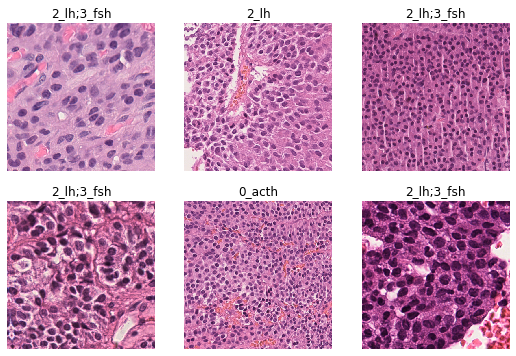

In [219]:
dls.show_batch()

# learner

## n

In [14]:
n = np.load('n_ent_f2.npy')
print(n)
#m = n+1
m=1
np.save('n_ent_f2.npy', m)
print(m)

1
1


## create

In [15]:
arch = torchvision.models.resnet.resnext101_32x8d

learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     #metrics=[fastai.metrics.accuracy_multi, fastai.metrics.RocAucMulti],
                     pretrained=True, path=PATH)

## name

In [16]:
epochs_frozen = 1
epochs_unfrozen = 3

In [17]:
#nameBase = f'{n}-fastai2-{arch.__name__}-size{final_size}-bs{bs}-epochs_head{epochs_frozen}'\
#                f'epochs_complete{epochs_unfrozen}-seed_{seed}-n_splits_{n_splits}'\
#                f'-tiles_1+2+3-cross_valid_iteration_{current_iteration}'


nameBase = f'{n}-fastai2-{arch.__name__}-size={final_size}-bs={bs}-epochs_head={epochs_frozen}'\
                f'epochs_complete={epochs_unfrozen}-seed={seed}-train_size={train_size}-val_size={validation_size}'\
                f'-tiles_1+2+3-subset_of_5000_randomly_chosen_tiles'


nameBase

'1-fastai2-resnext101_32x8d-size=512-bs=6-epochs_head=1epochs_complete=3-seed=19-train_size=0.8-val_size=0.2-tiles_1+2+3-subset_of_5000_randomly_chosen_tiles'

In [18]:
learner.path

Path('/home/Deep_Learner/private/datasets/Hypophysenadenome')

## train

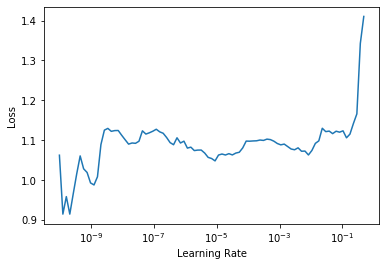

In [19]:
lr_min, lr_steep=learner.lr_find(start_lr=1e-10, end_lr=10)

In [22]:
lr1 = 1e-3

In [24]:
learner.fit_one_cycle(n_epoch=epochs_frozen, lr_max=lr1)

epoch,train_loss,valid_loss,time
0,0.550725,0.435847,05:35


In [25]:
nameHead = f'{nameBase}-head';nameHead

'1-fastai2-resnext101_32x8d-size=512-bs=6-epochs_head=1epochs_complete=3-seed=19-train_size=0.8-val_size=0.2-tiles_1+2+3-subset_of_5000_randomly_chosen_tiles-head'

In [26]:
learner.save(nameHead)

Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/models/1-fastai2-resnext101_32x8d-size=512-bs=6-epochs_head=1epochs_complete=3-seed=19-train_size=0.8-val_size=0.2-tiles_1+2+3-subset_of_5000_randomly_chosen_tiles-head.pth')

In [27]:
learner.unfreeze()

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=9.12010818865383e-07)

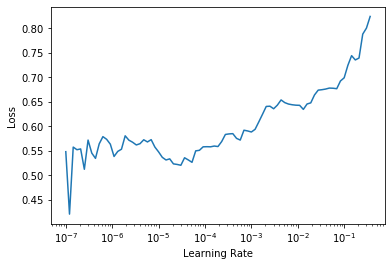

In [28]:
learner.lr_find()

In [29]:
lr2 = 1e-7 
lr3 = 1e-6

In [30]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, lr_max=[lr2, lr3])

epoch,train_loss,valid_loss,time
0,0.485094,0.424485,07:58
1,0.515143,0.417012,07:57
2,0.497364,0.415671,07:58


In [31]:
nameComplete = f'{nameBase}-complete'; nameComplete

'1-fastai2-resnext101_32x8d-size=512-bs=6-epochs_head=1epochs_complete=3-seed=19-train_size=0.8-val_size=0.2-tiles_1+2+3-subset_of_5000_randomly_chosen_tiles-complete'

In [32]:
learner.save(nameComplete)

Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/models/1-fastai2-resnext101_32x8d-size=512-bs=6-epochs_head=1epochs_complete=3-seed=19-train_size=0.8-val_size=0.2-tiles_1+2+3-subset_of_5000_randomly_chosen_tiles-complete.pth')

## load model weights

In [22]:
model_path = PATH/'models/1-fastai2-resnext101_32x8d-size=512-bs=6-epochs_head=1epochs_complete=3-seed=19-train_size=0.8-val_size=0.2-tiles_1+2+3-subset_of_5000_randomly_chosen_tiles-complete'

In [23]:
learner.load(model_path)

### weights trained with fastai1

In [15]:
##
# does not work, predictions are garbage now //TODO: try and train some more after loading the weights
##

# In fastai1 the bias of these two layers of the custom head is set to True. In fastai2 it is set to False.
# Since I want to load model weights, that were trained with fastai1, the two layers need to be replaced, so that the weights
# can be loaded correctly
#learner.model[1][4] = torch.nn.Linear(in_features=4096, out_features=512, bias=True)
#learner.model[1][8] = torch.nn.Linear(in_features=512, out_features=4, bias=True)
#
##model_path = PATH/'models/13-resnext/13-resnext_cross-valid-iteration-0/models/bestmodel_lr2=1e-7--lr3=1e-6_2nd_run_9'
#model_path = PATH/'models/12-resnext101_32x8d-size512-bs6-epochs_head5-epochs_complete10-seed_23/12-resnext101_32x8d-size512-bs6-epochs_head5-epochs_complete10-seed_23-complete'
#learner.load(model_path)

# prediction

In [228]:
from postprocessing.predictor import Predictor

In [229]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

In [230]:
predictor.predict_on_tiles(prediction_type=shared.enums.PredictionType.preextracted_tiles, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=512, batch_size=7)


# 5 times the same weights, just for testing
#iter_to_weight_test = {0:model_path, 1:model_path, 2:model_path, 3:model_path, 4:model_path}

#predictor.predict_on_tiles_KFold_cross_validation(k=5,
#                                                  seed=seed,
#                                                  iteration_to_weights=iter_to_weight_test,
#                                                    prediction_type=shared.enums.PredictionType.preextracted_tiles, 
#                                                  tile_size=512, 
#                                                  batch_size=7)

In [231]:
thresholds = {'0_acth':0.5, '1_silent':0.5, '2_lh':0.5, '3_fsh':0.5}
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds_tile_level = thresholds,
                                                thresholds_higher_level = thresholds)

In [ ]:
#predictor.export_dataframe(dataset_type=shared.enums.DatasetType.all, level=shared.enums.DataframeLevel.case_level)

In [20]:
#predictor.export_dataframe(dataset_type=shared.enums.DatasetType.all, level=shared.enums.DataframeLevel.slide_level)

In [29]:
#for t in patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation):
#    print(t.predictions_raw)
#    print(t.predictions_thresh)

In [22]:
#for p in patient_manager.get_patients(dataset_type=shared.enums.DatasetType.validation):
#    for case in p.cases:
#        print(f'{case.case_id}: {case.predictions_thresh}')

## check that tiles are everywhere in the same order

In [238]:
tiles_valid = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation)

In [236]:
dl_pred, tiles_to_predict = predictor.build_dataloader(shared.enums.PredictionType.preextracted_tiles, 
                             dataset_type=shared.enums.DatasetType.validation, tile_size=512, batch_size=6)

In [237]:
preds = learner.get_preds(dl=dl_pred, with_input=True)

In [239]:
len(tiles_valid) == len(tiles_to_predict) == dl_pred.n == len(preds[0])

True

In [242]:
import PIL

In [263]:
i = random.randint(0, len(tiles_valid)-1)
print(i)

1127


In [ ]:
PIL.Image.open(tiles_valid[i].tile_path)

In [ ]:
PIL.Image.open(tiles_to_predict[i].tile_path)

In [ ]:
dl_pred.dataset[i][0]

In [ ]:
plt.imshow(  preds[0][i].permute(1, 2, 0)  )

# evaluation

In [545]:
from postprocessing.evaluator import Evaluator

In [546]:
evaluator = Evaluator(predictor=predictor)

In [547]:
evaluator.calculate_accuracy_per_class(dataset_type=shared.enums.DatasetType.validation, 
                                       level=shared.enums.EvaluationLevel.case)

100%|██████████| 55/55 [00:00<00:00, 42111.49it/s]


{'0_acth': 0.8909090909090909,
 '1_silent': 0.9272727272727272,
 '2_lh': 0.9090909090909091,
 '3_fsh': 0.8545454545454545}

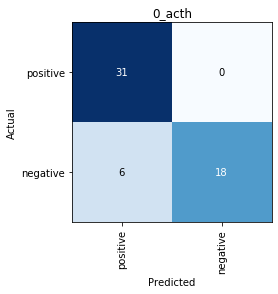

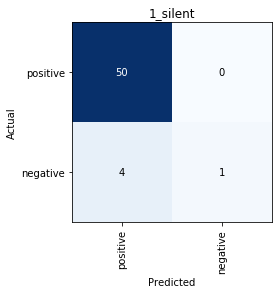

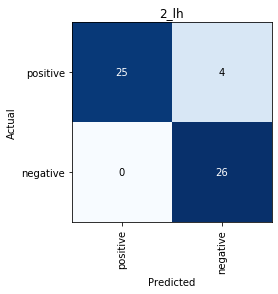

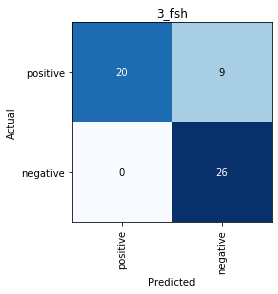

In [148]:
evaluator.plot_confusion_matrix(dataset_type=shared.enums.DatasetType.validation, 
                                level=shared.enums.EvaluationLevel.case)

  0%|          | 0/4 [00:00<?, ?it/s]

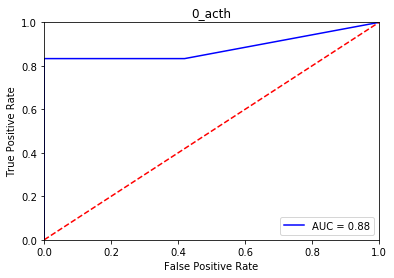

 25%|██▌       | 1/4 [00:00<00:00,  9.61it/s]

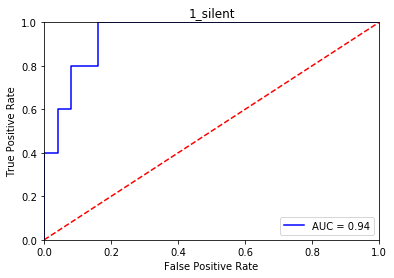

 50%|█████     | 2/4 [00:00<00:00,  9.62it/s]

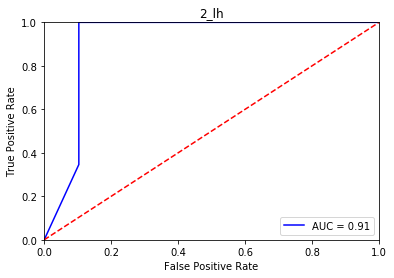

 75%|███████▌  | 3/4 [00:00<00:00,  9.65it/s]

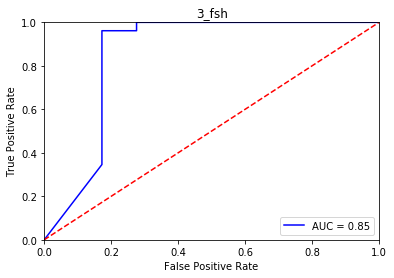

100%|██████████| 4/4 [00:00<00:00,  9.63it/s]


In [149]:
evaluator.plot_roc_curves(dataset_type=shared.enums.DatasetType.validation, level=shared.enums.EvaluationLevel.case)

  0%|          | 0/4 [00:00<?, ?it/s]

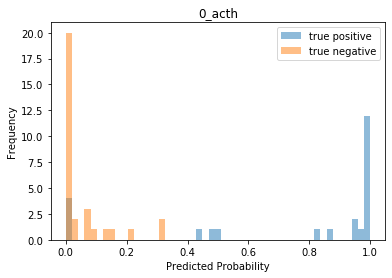

 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

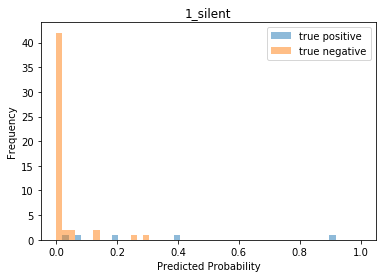

 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

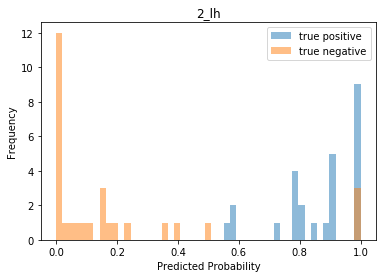

 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

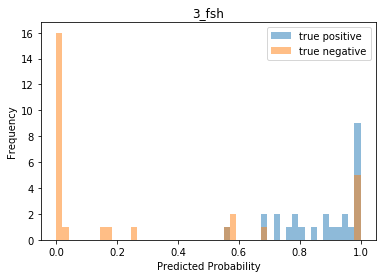

100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


In [150]:
evaluator.plot_probability_histograms(dataset_type=shared.enums.DatasetType.validation, 
                                      level=shared.enums.EvaluationLevel.case)

In [151]:
evaluator.classification_report(dataset_type=shared.enums.DatasetType.validation, 
                                      level=shared.enums.EvaluationLevel.case)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        24
           1       1.00      0.20      0.33         5
           2       0.87      1.00      0.93        26
           3       0.74      1.00      0.85        26

   micro avg       0.85      0.88      0.86        81
   macro avg       0.90      0.74      0.74        81
weighted avg       0.87      0.88      0.85        81
 samples avg       0.84      0.86      0.84        81



/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


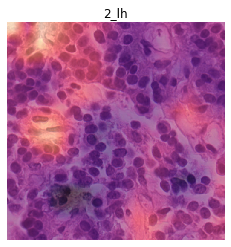

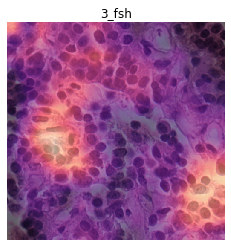

In [122]:
image = learner.dls.train_ds[0][0]
thresholds = numpy.repeat(0.5, len(predictor.get_classes()))
take_predicted_class_indices = False
class_indices = [2,3]
model_layer = learner.model[0][-4]
model_layer = None

evaluator.grad_cam(image=image, 
                   thresholds=thresholds, 
                   take_predicted_class_indices=take_predicted_class_indices, 
                   class_indices=class_indices, model_layer=model_layer)

,patient,slide,target,predicted,probabilities,loss
0,1479-16,1479-16-III-HE,"[0_acth, 1_silent]",[3_fsh],"{'0_acth': 0.22034293413162231, '1_silent': 0.0030442827846854925, '2_lh': 0.44879505038261414, '3_fsh': 0.5551495552062988}",2.178182
1,1089-13,1089-13-III-HE,"[2_lh, 3_fsh]",[0_acth],"{'0_acth': 0.9584945440292358, '1_silent': 0.29830825328826904, '2_lh': 0.06513326615095139, '3_fsh': 0.09182309359312057}",2.163851
2,1867-12,1867-12-III-HE,"[2_lh, 3_fsh]",[0_acth],"{'0_acth': 0.9533357620239258, '1_silent': 0.28674909472465515, '2_lh': 0.21004396677017212, '3_fsh': 0.0311768539249897}",2.107804
3,1479-16,1479-16-III-HE,"[0_acth, 1_silent]",[],"{'0_acth': 0.32560640573501587, '1_silent': 0.003378403838723898, '2_lh': 0.19498462975025177, '3_fsh': 0.3698945939540863}",1.872795
4,1089-13,1089-13-III-HE,"[2_lh, 3_fsh]",[0_acth],"{'0_acth': 0.9113990664482117, '1_silent': 0.017350362613797188, '2_lh': 0.2502664029598236, '3_fsh': 0.03242406249046326}",1.813800
5,2203-14,2203-14-III-HE,"[2_lh, 3_fsh]",[0_acth],"{'0_acth': 0.8478176593780518, '1_silent': 0.067238949239254, '2_lh': 0.05557091906666756, '3_fsh': 0.0937386080622673}",1.802406
6,1479-16,1479-16-III-HE,"[0_acth, 1_silent]",[],"{'0_acth': 0.3452998101711273, '1_silent': 0.0036279852502048016, '2_lh': 0.14622046053409576, '3_fsh': 0.2803679406642914}",1.792379
7,1335-13,1335-13-III-HE,"[2_lh, 3_fsh]","[0_acth, 1_silent]","{'0_acth': 0.6971369981765747, '1_silent': 0.7294712066650391, '2_lh': 0.25098976492881775, '3_fsh': 0.03946803882718086}",1.779115
8,1479-16,1479-16-III-HE,"[0_acth, 1_silent]",[2_lh],"{'0_acth': 0.49137479066848755, '1_silent': 0.010473908856511116, '2_lh': 0.7122455835342407, '3_fsh': 0.42313969135284424}",1.766305
9,1661-11,1661-11-Z-HE,"[2_lh, 3_fsh]",[0_acth],"{'0_acth': 0.7048149704933167, '1_silent': 0.37891915440559387, '2_lh': 0.05187911540269852, '3_fsh': 0.0995083600282669}",1.740700


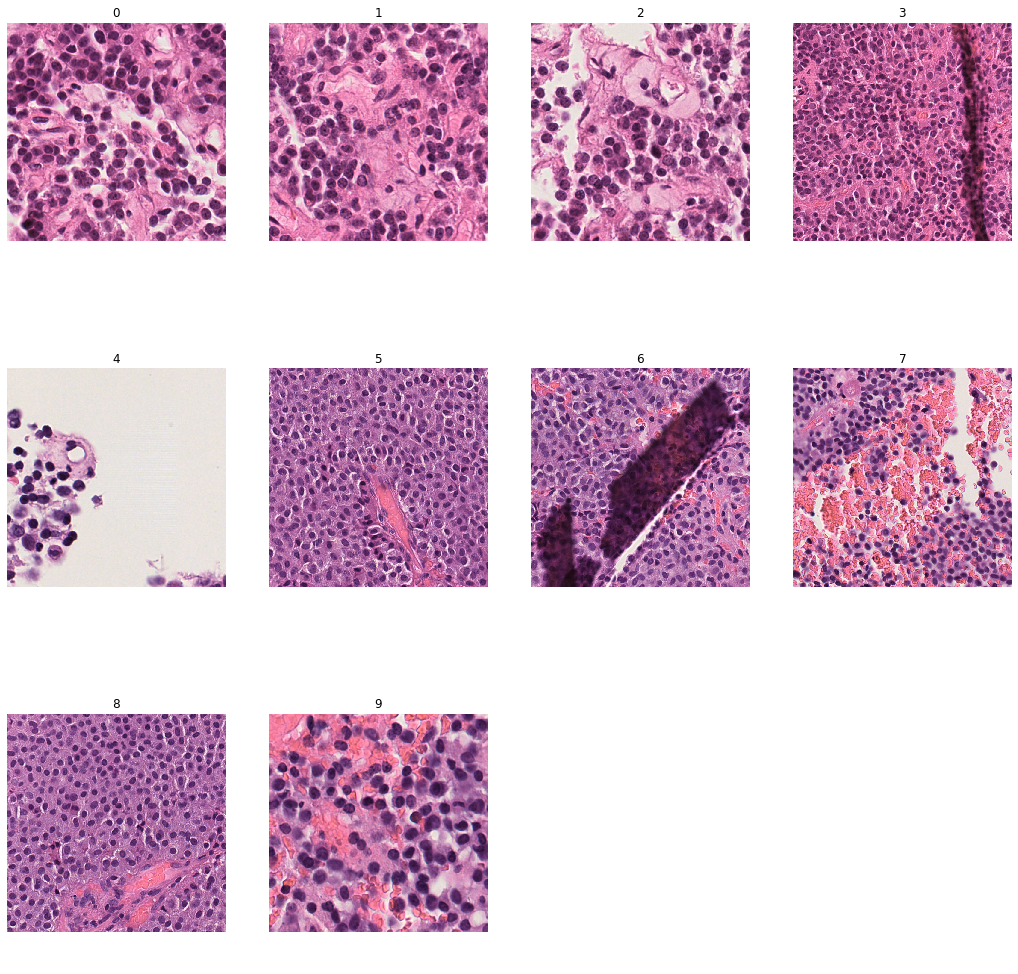

In [550]:
evaluator.plot_top_losses(dataset_type=shared.enums.DatasetType.validation, descending=True)

In [554]:
evaluator.get_df_of_k_top_ordered_by_metric(dataset_type=shared.enums.DatasetType.validation, 
                                            level=shared.enums.EvaluationLevel.case)

,case,target,predicted,probabilities,metric
0,1739-12,[0_acth],"[2_lh, 3_fsh]","{'0_acth': 0.0, '1_silent': 0.0, '2_lh': 1.0, '3_fsh': 1.0}",0.750000
1,1366-14,[0_acth],"[2_lh, 3_fsh]","{'0_acth': 0.0, '1_silent': 0.0, '2_lh': 1.0, '3_fsh': 1.0}",0.750000
2,848-13,[0_acth],[3_fsh],"{'0_acth': 0.0, '1_silent': 0.0, '2_lh': 0.0, '3_fsh': 1.0}",0.500000
3,536-14,[0_acth],[2_lh],"{'0_acth': 0.0, '1_silent': 0.0, '2_lh': 1.0, '3_fsh': 0.0}",0.500000
4,248-18,[0_acth],[2_lh],"{'0_acth': 0.0, '1_silent': 0.0, '2_lh': 1.0, '3_fsh': 0.0}",0.500000
5,1479-16,"[0_acth, 1_silent]",[0_acth],"{'0_acth': 0.5106382978723404, '1_silent': 0.02127659574468085, '2_lh': 0.10638297872340426, '3_fsh': 0.2553191489361702}",0.457447
6,2203-14,"[3_fsh, 2_lh]",[3_fsh],"{'0_acth': 0.2857142857142857, '1_silent': 0.0, '2_lh': 0.42857142857142855, '3_fsh': 0.5714285714285714}",0.321429
7,1089-13,"[3_fsh, 2_lh]","[2_lh, 3_fsh]","{'0_acth': 0.375, '1_silent': 0.0, '2_lh': 0.5625, '3_fsh': 0.5625}",0.312500
8,2246-15,[2_lh],"[2_lh, 3_fsh]","{'0_acth': 0.0, '1_silent': 0.0, '2_lh': 0.8076923076923077, '3_fsh': 1.0}",0.298077
9,1760-14,[2_lh],"[2_lh, 3_fsh]","{'0_acth': 0.13043478260869565, '1_silent': 0.0, '2_lh': 0.5869565217391305, '3_fsh': 0.6086956521739131}",0.288043
